# Viewing the data

In [1]:
# dependencies
%matplotlib inline
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn import svm

In [2]:
# config
JSONDATAPATH = './ht_wt_data_2014.json'

In [3]:
# load data from .json file
with open(JSONDATAPATH) as data_file:
    data = json.load(data_file)

In [4]:
# create list of attributes
# Note: in this case; group=sport, attribute=height/weight
attribute_list = []
for group in data:
    for entry in data[group]:
        for attribute in entry:
            if attribute not in attribute_list:
                attribute_list.append(attribute)

In [5]:
# create dict for each outter level group
group_container = {}
for group in data:
    group_container[group] = {}

# create numpy arrays of each attribute (height/weight) for each group (sport)
for attribute in attribute_list:
    for group in data:
        cur_list = []
        for entry in data[group]:
            cur_list.append(int(entry[attribute]))
        group_container[group][attribute] = np.asarray(cur_list)

## All data loaded loaded to dictionary;
example: `group_container = {nba: {weight: np.array, height: np.array}, ...}`

In [6]:
# Peek into the data
for attribute in attribute_list:
    print(attribute)
    print("\t{0:<8s}{1:<8s}{2:<8s}{3:<8s}".format("MIN","MEAN","MAX", "N"))
    for group in group_container:
        print("{0:<5s} {min:5d} {mean:9.2f} {max:5d} {n:6d}".format(group, min=np.amin(group_container[group][attribute]), mean=np.mean(group_container[group][attribute]), max=np.amax(group_container[group][attribute]), n=len(group_container[group][attribute])))
    print("\n")

Height
	MIN     MEAN    MAX     N       
nba      69     79.07    87    505
epl      63     71.74    80    526
nhl      65     73.26    81    717


Weight
	MIN     MEAN    MAX     N       
nba     157    220.67   290    505
epl     126    168.67   223    526
nhl     150    202.42   260    717




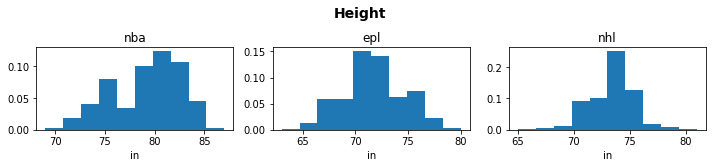

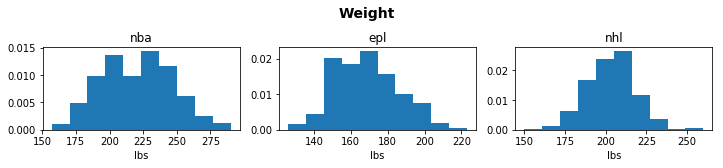

In [7]:
# create histogram array
num_x = len(attribute_list)
num_y = len(group_container)

for attribute in attribute_list:
    fig, axes = plt.subplots(1, num_y, figsize=(12,2))
    fig.suptitle(attribute, fontsize=14, fontweight='bold')
    fig.subplots_adjust(top=.7)
    index = 0
    for group in group_container:
        axes[index].hist(group_container[group][attribute], normed=True)
        axes[index].set_title(group)
        if attribute == 'Height':
            axes[index].set_xlabel('in')
        if attribute == 'Weight':
            axes[index].set_xlabel('lbs')
        index += 1
    plt.show()

### Overlay and scale the graphs

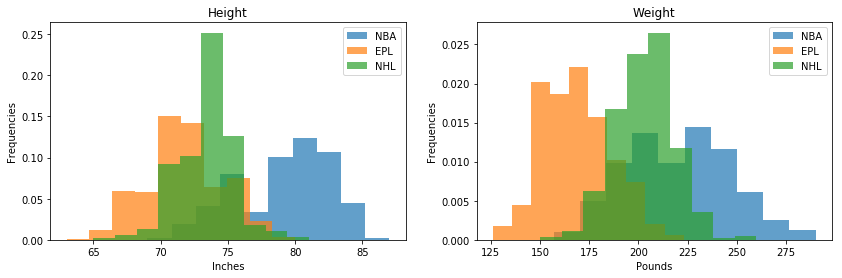

In [8]:
fig, axes = plt.subplots(1, num_x, figsize=(14,4))
for index, attribute in enumerate(attribute_list):
    for group in group_container:
        axes[index].hist(group_container[group][attribute], normed=True, label=group.upper(), histtype='stepfilled', alpha=0.7)
        if attribute == 'Height':
            axes[index].set_xlabel('Inches')
            axes[index].set_title('Height')
        if attribute == 'Weight':
            axes[index].set_xlabel('Pounds')
            axes[index].set_title('Weight')
        axes[index].set_ylabel('Frequencies')
        axes[index].legend()

plt.show()

### As box plots

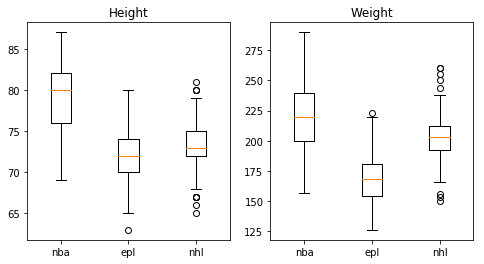

In [9]:
fig, axes = plt.subplots(1, num_x, figsize=(8,4))
for index, attribute in enumerate(attribute_list):
    plot_list = []
    for i, group in enumerate(group_container):
        plot_list.append(group_container[group][attribute])

    axes[index].boxplot(plot_list)
    axes[index].set_xticklabels(group_container)
    axes[index].set_title(attribute)

plt.show()

### Height vs Weight

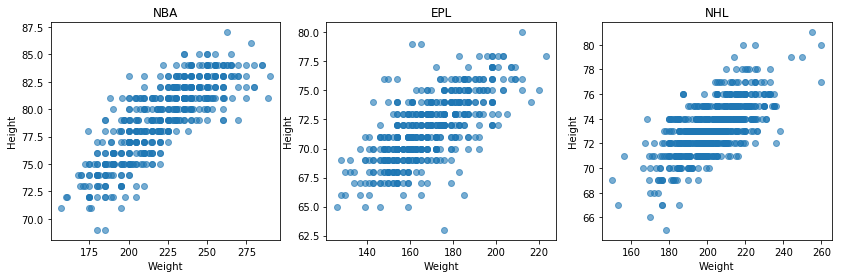

In [10]:
# first glance
fig, axes = plt.subplots(1, num_y, figsize=(14,4))
for i, group in enumerate(group_container):
    axes[i].scatter(group_container[group]['Weight'], group_container[group]['Height'], alpha=0.6)
    axes[i].set_title(group.upper())
    axes[i].set_ylabel('Height')
    axes[i].set_xlabel('Weight')

### Overlay and scale the graphs

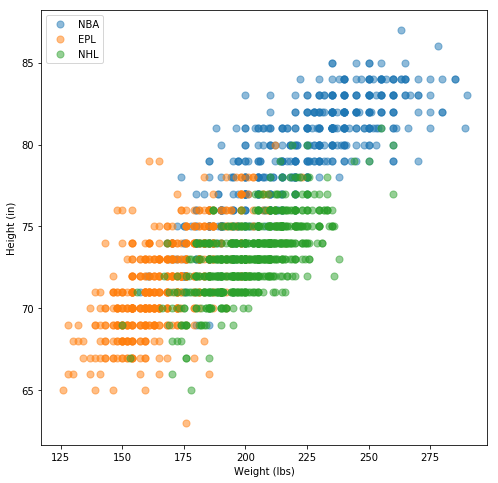

In [11]:
fig, ax = plt.subplots(figsize=(8,8))
for i, group in enumerate(group_container):
    ax.scatter(group_container[group]['Weight'], group_container[group]['Height'], alpha=0.5, label=group.upper(), s=50)
    ax.legend()
    ax.set_ylabel('Height (in)')
    ax.set_xlabel('Weight (lbs)')
plt.show()

In [12]:
# Change the view a little bit

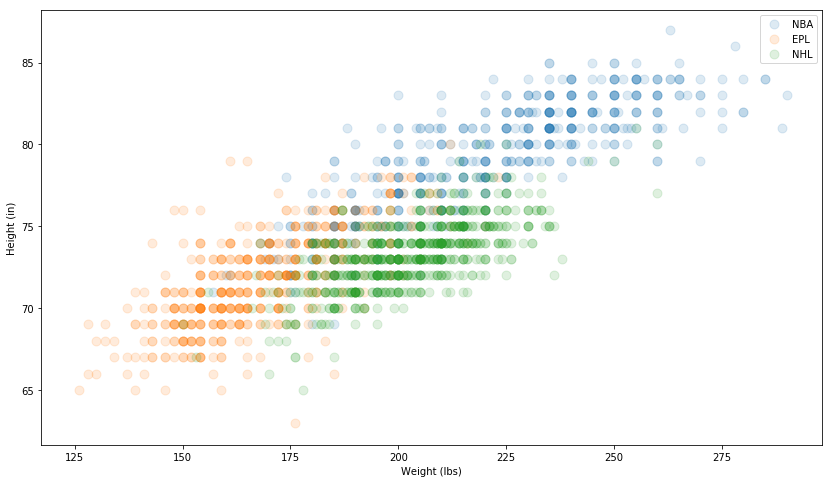

In [13]:
fig, ax = plt.subplots(figsize=(14,8))
for i, group in enumerate(group_container):
    ax.scatter(group_container[group]['Weight'], group_container[group]['Height'], alpha=0.15, label=group.upper(), s=80)
    ax.legend()
    ax.set_ylabel('Height (in)')
    ax.set_xlabel('Weight (lbs)')
plt.show()

In [14]:
# create X[height, weight] and Y[label]
X = []
Y = []
for index, group in enumerate(group_container):
    X_ = list(zip(group_container[group]['Weight'], group_container[group]['Height']))
    X_ = [list(elem) for elem in X_]
    Y_ = [index]*len(X_)
    X.extend(X_)
    Y.extend(Y_)

# classifier
# `C` param doc: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# default value is 1
C = 1.0
# since the dataset is unblanced, we will use the class_weight='balanced'
svc = svm.SVC(kernel='linear', C=C, class_weight="balanced")
svc.fit(X, Y)

# create a mesh/grid that will plot the svm boundaries
h = 0.1  # step size in the mesh/grid
# +/- 5 lbs to extend the grid to the plot boundry
# +/- 2 in to extend the grid to the plot boundry
x_min = min(point[0] for point in X) - 5
y_min = min(point[1] for point in X) - 2
x_max = max(point[0] for point in X) + 5
y_max = max(point[1] for point in X) + 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

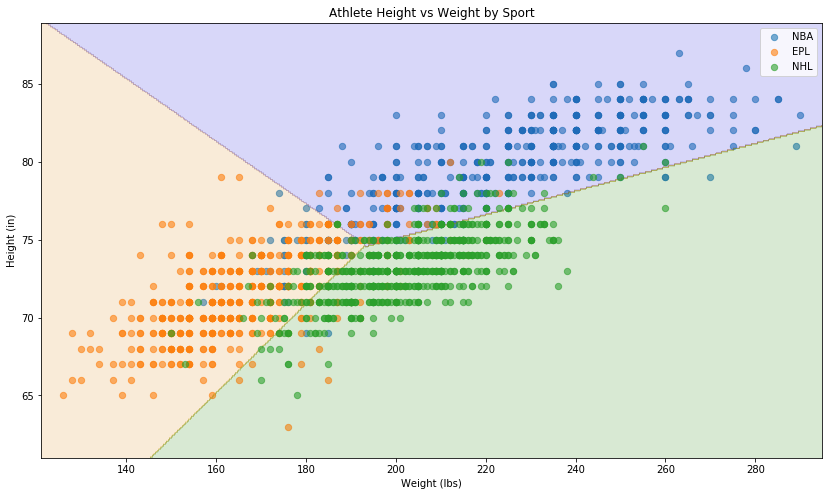

In [15]:
fig, ax = plt.subplots(figsize=(14,8))
for i, group in enumerate(group_container):
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=LinearSegmentedColormap.from_list('mycmap', ['blue','orange','green']), alpha=0.06)
    
    ax.scatter(group_container[group]['Weight'], group_container[group]['Height'], alpha=0.6, label=group.upper(), s=40)
    ax.legend()
    ax.set_title('Athlete Height vs Weight by Sport')
    ax.set_ylabel('Height (in)')
    ax.set_xlabel('Weight (lbs)')
plt.show()

### Just how 'accurate' is this prediction

In [16]:
meanAcc = svc.score(X, Y)
print("{0:.2f}%".format(meanAcc*100))

81.41%


### Considerations
* Our sample size is small.  We only have a ~500 players for each sport
* Since our dataset is unbalanced, a `class_weight="balanced"` argument was used.
    * I believe this is working as intended, but this would need to be verified.  Without this argument we stay the same at ~82% accuracy


### Notes
* `>80%` accuracy is surprising.
    * I expected to find a trend, but I didn't expect it to be this significant